**LGR with MVR and SFR**

In [1]:
import os ; import pathlib as pl ; import pandas as pd ; import numpy as np ;  import matplotlib.pyplot as plt ; from pathlib import Path  
from flopy.plot.styles import styles ; import shapefile as shp ; import matplotlib as mpl ; import flopy ; import flopy.utils.binaryfile as bf 
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True) ; from flopy.utils.lgrutil import Lgr 

In [2]:
sim_ws    = Path("./23_LGR")                         ; sim_ws.mkdir(exist_ok=True)     ; sim_name = example_name = "ex-gwf-lgr"
exe_name  = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'  ; workspace = figs_path = sim_ws       
sim_data  = Path("./_aux/23_LGR")                    ; sim_data.mkdir(exist_ok=True)

In [3]:
length_units = "meters" ; time_units = "days" ; nouter = 100  ; ninner = 300 ;hclose = 0.0000001 ;rclose = 0.000001 ;relax = 0.97  # numdays = 1
nlayp = 3 ;nrowp = 15   ;ncolp = 15       ;delrp = 102.94     ; delcp  = 68.63 ;dum1 = 5 ;dum2 = 5 ;dum3 = 20.588 ;dum4 = 13.725 ;k11 = 1 ;k33 = 1 ;
delrp = 1544.1/ncolp    ;delcp = 1029.4/nrowp ;perlen = [1]*1 ; nper   = len(perlen) ;nstp = [1]*1 ;tsmult = [1.0]*1 ;

x = [round(x, 3) for x in np.linspace(50.0, 45.0, ncolp)]       ; topp   = np.repeat(x, nrowp).reshape((15, 15)).T
z = [round(z, 3) for z in np.linspace(50.0, 0.0, nlayp + 1)]    ; botmp  = [topp - z[len(z) - 2], topp - z[len(z) - 3], topp - z[0]]
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)            ; idomainp[0:2, 6:11, 2:8] = 0  # Zero out where the child grid will reside
icelltype = [1, 0, 0]  ; idomainp[0] ; # Water table resides in layer 1         # botmp[1]  #

In [4]:
import pickle
with open(sim_data/ "01_connsp"   , 'rb') as handle: connsp = pickle.load(handle)    ; connsp2 = pd.DataFrame(connsp)       ; connsp2.to_csv    (sim_ws/ "a00_connsp.csv")   # ; print('Qde_connsp',len(connsp))
with open(sim_data/ "01_sfrcells" , 'rb') as handle: sfrcells = pickle.load(handle)  ; sfrcells2 = pd.DataFrame(sfrcells)   ; sfrcells2.to_csv  (sim_ws/ "b01_sfrcells.csv") # ; print('Qde_sfrcells',len(sfrcells))
with open(sim_data/ "01_sfrcellsc", 'rb') as handle: sfrcellsc = pickle.load(handle) ; sfrcellsc2 = pd.DataFrame(sfrcellsc) ; sfrcellsc2.to_csv (sim_ws/ "c01_sfrcellsc.csv") #; print('Qde_sfrcellsc',len(sfrcellsc))
with open(sim_data/ "01_rlen"     , 'rb') as handle: rlen = pickle.load(handle)      ; rlen2 = pd.DataFrame(rlen)           ; rlen2.to_csv      (sim_ws/ "b02_rlen.csv")     # ; print('Qde_rlen',len(rlen))
with open(sim_data/ "01_rlenc"    , 'rb') as handle: rlenc = pickle.load(handle)     ; rlenc2 = pd.DataFrame(rlenc)         ; rlenc2.to_csv     (sim_ws/ "c02_rlenc.csv")     #; print('Qde_rlenc',len(rlenc))
with open(sim_data/ "01_rbtp"     , 'rb') as handle: rbtp = pickle.load(handle)      ; rbtp2 = pd.DataFrame(rbtp)           ; rbtp2.to_csv      (sim_ws/ "b03_rbtp.csv")     # ; print('Qde_rbtp',len(rbtp))
with open(sim_data/ "01_rbtpc"    , 'rb') as handle: rbtpc = pickle.load(handle)     ; rbtpc2 = pd.DataFrame(rbtpc)         ; rbtpc2.to_csv     (sim_ws/ "c03_rbtpc.csv")     #; print('Qde_rbtpc',len(rbtpc))

In [5]:
rwid  = 5     ; rgrd1 = 0.12869035e-02     ; rgrd2 = 0.12780087e-02  
rbth  = 1.5   ; rbhk  = 0.1                ; man   = 0.04             ; ustrf = 1.0     ; ndv = 0 ; 
rwidc = 5     ; rgrdc  = 0.14448310e-02    ; rbthc = 1.5              ; rbhkc = 0.1     ; manc = 0.04 ; ustrfc = 1.0 ; ndvc = 0 ; 

In [6]:
pkdat = []
for i in np.arange(len(rlen)):
    if i < 8:       rgrd = rgrd1
    else:           rgrd = rgrd2
    ncon = len(connsp[i]) - 1        ; pkdat.append((i ,sfrcells[i] ,rlen[i] ,rwid ,rgrd ,rbtp[i] ,rbth ,rbhk ,man ,ncon ,ustrf ,ndv))
connsc = []
for i in np.arange(89):
    if i == 0:     connsc.append((i, -1 * (i + 1)))
    elif i == 88:  connsc.append((i,       i - 1 ))
    else:          connsc.append((i,       i - 1   , -1 * (i + 1)))
connsc2 = pd.DataFrame(connsc) ;  connsc2.to_csv    (sim_ws/ "a01_connsc.csv")
pkdatc = []
for i in np.arange(len(rlenc)):
    nconc = len(connsc[i]) - 1      ; pkdatc.append((i ,sfrcellsc[i] ,rlenc[i] ,rwidc ,rgrdc ,rbtpc[i] ,rbthc ,rbhkc ,manc ,nconc ,ustrfc ,ndvc))
sfrspd = {0: [[0, "INFLOW", 40.0]]}  ; sfrspdc = {0: [[0, "INFLOW", 0.0]]}
sa = pd.DataFrame(pkdat); sa.columns= ('i','sfrcells[i]','rlen[i]','rwid','rgrd','rbtp[i]','rbth','rbhk','man','ncon','ustrf','ndv')
sa.set_index('i', inplace=True, drop=True) ; ab2 = sa['sfrcells[i]']; ab3 = ab2.tolist()  ; np.savetxt(sim_ws / "bb01n_pkdat.csv", ab3, delimiter=",")
ab4=pd.DataFrame(ab3); ab5 = ab4.rename(columns=lambda x:'sfrcells'+str(x)) ; df=pd.concat([sa[:],ab5[:]],axis=1) ; df.to_csv(sim_ws/"bb01y_pkdat.csv") 
sa = pd.DataFrame(pkdatc); sa.columns= ('i','sfrcells[i]','rlen[i]','rwid','rgrd','rbtp[i]','rbth','rbhk','man','ncon','ustrf','ndv')
sa.set_index('i', inplace=True, drop=True) ; ab2 = sa['sfrcells[i]']; ab3 = ab2.tolist()  ; np.savetxt(sim_ws / "cc02n_pkdatc.csv", ab3, delimiter=",")
ab4=pd.DataFrame(ab3); ab5 = ab4.rename(columns=lambda x:'sfrcells'+str(x)) ; df=pd.concat([sa[:],ab5[:]],axis=1) ; df.to_csv(sim_ws/"cc02y_pkdatc.csv") 

In [7]:
def build_models(sim_name, silent=False):
    name = "lgr"  ;  gwfname = "gwf-"+ name  ; gwfname = gwfname+"-parent" ;     gwfnamec = "gwf-" + name + "-child" ;   tdis_rc = []   
    for i in range(len(perlen)): tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    rowList = np.arange(0, nrowp).tolist()  ; layList = np.arange(0, nlayp).tolist() ; chdspd_left = [] ; chdspd_right = []
    hd_left = 49.75 ; hd_right = 44.75
    for l in layList:
        for r in rowList:
            chdspd_left.append([(l, r, 0), hd_left]) ; chdspd_right.append([(l, r, ncolp - 1), hd_right])
    chdspd_L = {0: chdspd_left}  ;     chdspd_R = {0:chdspd_right}

    ncpp = 3 ; ncppl=[3 ,3 ,0]
    lgr = Lgr(nlayp ,nrowp ,ncolp ,delrp ,delcp ,topp ,botmp ,idomainp ,ncpp=ncpp ,ncppl=ncppl ,xllp=0.0 ,yllp=0.0)
    delrc, delcc  = lgr.get_delr_delc() ; idomainc = lgr.get_idomain()  ; topc, botmc = lgr.get_top_botm()  
    child_dis_shp = lgr.get_shape()     ; nlayc=child_dis_shp[0] ; nrowc=child_dis_shp[1] ; ncolc=child_dis_shp[2]    ; icelltypec = [1 ,1 ,1 ,0 ,0 ,0]
    strt = [topp-0.25,topp-0.25,topp-0.25]  ; strtc = [topc-0.25,topc-0.25,topc-0.25   ,topc-0.25,topc-0.25 ,topc-0.25]
    # __________________________________________________________________________________________________________________________________________#
    sim = flopy.mf6.MFSimulation     (sim_name = sim_name ,version = "mf6" ,sim_ws = sim_ws ,exe_name = "mf6" ,continue_ = True ,)
    flopy.mf6.ModflowTdis  (sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    gwf    = flopy.mf6.ModflowGwf    (sim ,modelname = gwfname ,save_flows = True ,newtonoptions = "newton" ,model_nam_file = f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms    (sim ,print_option = "SUMMARY" ,outer_dvclose = hclose ,outer_maximum = nouter ,under_relaxation = "NONE",
                                      inner_maximum = ninner ,inner_dvclose = hclose ,rcloserecord = rclose ,linear_acceleration = "BICGSTAB",
                                      scaling_method = "NONE" ,reordering_method = "NONE" ,relaxation_factor = relax ,filename = f"{gwfname}.ims")
    sim.register_ims_package(imsgwf ,[gwf.name])
    flopy.mf6.ModflowGwfdis (gwf ,nlay = nlayp ,nrow = nrowp ,ncol = ncolp ,delr = delrp ,delc = delcp ,top = topp ,botm = botmp,
                             idomain = idomainp ,filename = f"{gwfname}.dis")
    flopy.mf6.ModflowGwfic  (gwf, strt=strt, filename=f"{gwfname}.ic")
    flopy.mf6.ModflowGwfnpf (gwf ,save_flows=True ,alternative_cell_averaging="AMT-LMK" ,icelltype=icelltype ,k=k11 ,k33=k33,
                             save_specific_discharge=False ,filename=f"{gwfname}.npf")
    flopy.mf6.ModflowGwfoc  (gwf ,budget_filerecord=f"{gwfname}.bud" ,head_filerecord=f"{gwfname}.hds",
                             headprintrecord=[("COLUMNS" ,10 ,"WIDTH" ,15 ,"DIGITS" ,6 ,"GENERAL")],
                             saverecord=[("HEAD" ,"LAST") ,("BUDGET" ,"LAST")] ,printrecord=[("HEAD" ,"LAST") ,("BUDGET" ,"LAST")])
    flopy.mf6.ModflowGwfchd (gwf ,maxbound=len(chdspd_L) ,stress_period_data=chdspd_L ,save_flows=False,pname="CHD-1" ,filename=f"{gwfname}.chd1.chd")
    flopy.mf6.ModflowGwfchd (gwf ,maxbound=len(chdspd_R) ,stress_period_data=chdspd_R ,save_flows=False,pname="CHD-2" ,filename=f"{gwfname}.chd2.chd")
    flopy.mf6.ModflowGwfsfr (gwf ,print_stage=False ,print_flows=False ,budget_filerecord=gwfname+".sfr.bud" ,save_flows=True ,mover=True,
                             pname="SFR-parent" ,time_conversion=86400.0 ,boundnames=False ,nreaches=len(connsp) ,packagedata = pkdat,
                             connectiondata=connsp ,perioddata=sfrspd ,filename=f"{gwfname}.sfr")
    # __________________________________________________________________________________________________________________________________________#
    gwfc = flopy.mf6.ModflowGwf       (sim ,modelname=gwfnamec ,save_flows=True ,newtonoptions="newton" ,model_nam_file=f"{gwfnamec}.nam")
    flopy.mf6.ModflowGwfdis (gwfc ,nlay=nlayc ,nrow=nrowc ,ncol=ncolc ,delr=delrc ,delc=delcc ,top=topc ,botm=botmc ,
                             idomain=idomainc ,filename=f"{gwfnamec}.dis")
    flopy.mf6.ModflowGwfic  (gwfc ,strt=strtc ,filename=f"{gwfnamec}.ic")
    flopy.mf6.ModflowGwfnpf (gwfc ,save_flows=False ,alternative_cell_averaging="AMT-LMK" ,icelltype=icelltypec ,k=k11 ,k33=k33,
                             save_specific_discharge=False ,filename=f"{gwfnamec}.npf")
    flopy.mf6.ModflowGwfoc  (gwfc,budget_filerecord=f"{gwfnamec}.bud",head_filerecord=f"{gwfnamec}.hds",
                             headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                             saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")], printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])
    flopy.mf6.ModflowGwfsfr (gwfc ,print_stage=False ,print_flows=False ,budget_filerecord=gwfnamec+".sfr.bud" ,save_flows=True,
                             mover=True ,pname="SFR-child" ,time_conversion=86400.00 ,boundnames=False ,nreaches=len(connsc),
                             packagedata=pkdatc ,connectiondata=connsc ,perioddata=sfrspdc ,filename=f"{gwfnamec}.sfr")
    exchange_data = lgr.get_exchange_data()
    gwfgwf = flopy.mf6.ModflowGwfgwf  (sim ,exgtype="GWF6-GWF6" ,print_flows=True ,print_input=True ,exgmnamea=gwfname ,exgmnameb=gwfnamec,
                                       nexg=len(exchange_data) ,exchangedata=exchange_data ,mvr_filerecord=f"{name}.mvr" ,pname="EXG-1",
                                       filename=f"{name}.exg")

    mvrpack = [[gwfname, "SFR-parent"], [gwfnamec, "SFR-child"]]  ;    maxpackages = len(mvrpack)
    static_mvrperioddata =[[mvrpack[0][0],mvrpack[0][1],7  ,mvrpack[1][0],mvrpack[1][1],0 ,"FACTOR",1.0] 
                          ,[mvrpack[1][0],mvrpack[1][1],88 ,mvrpack[0][0],mvrpack[0][1],8 ,"FACTOR",1 ]] ; mvrspd={0:static_mvrperioddata}; maxmvr=2
    mvr = flopy.mf6.ModflowMvr(gwfgwf,modelnames=True,maxmvr=maxmvr,print_flows=True,maxpackages=maxpackages,packages=mvrpack,
                               perioddata=mvrspd,filename=f"{name}.mvr")
    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):   success, buff = sim.run_simulation(silent=silent, report=True)  ;     assert success, buff
def scenario(idx, silent=True):     
    sim     = build_models(example_name)
    if write: write_models(sim, silent=silent)
    if run:   run_models(sim, silent=silent)
scenario(0)

run_models took 339.89 ms


In [8]:
mf6a = build_models('gwf-lgr-child').get_model('gwf-lgr-child')  ; mf6b = build_models('gwf-lgr-parent').get_model('gwf-lgr-parent')
sfr_parent_bud_file = Path("./23_LGR/gwf-lgr-parent.sfr.bud")    ; modobjp = bf.CellBudgetFile(sfr_parent_bud_file, precision="double")
sfr_child_bud_file  = Path("./23_LGR/gwf-lgr-child.sfr.bud")     ; modobjc = bf.CellBudgetFile(sfr_child_bud_file , precision="double")
ckstpkper = modobjp.get_kstpkper()                               ; qp=[] ;qc=[] ;gwswp=[] ;gwswc=[] ;toMvrp=[] ;fromMvrp=[] ;toMvrc=[] ;fromMvrc=[]
xcenters, ycenters = mf6a.modelgrid.xycenters[0], mf6a.modelgrid.xycenters[1]  ; p1 = (xcenters[3], ycenters[3]) ; p2 = (xcenters[13], ycenters[13])

In [9]:
ncpp = 3 ; ncppl=[3 ,3 ,0] ; lgr = Lgr (nlayp,nrowp,ncolp   , delrp,delcp,topp,botmp    ,idomainp ,ncpp=ncpp ,ncppl=ncppl ,xllp=0.0 ,yllp=0.0)
lgr2 = pd.DataFrame(lgr.get_exchange_data())                ; lgr2.columns= ('parent','child','top_bot','idomainp','ncpp','ncppl')
ab2 = lgr2['parent'] ; ab3  = ab2.tolist()                  ; np.savetxt(sim_ws / "e01_temp.csv", ab3, delimiter=",")
ab4=pd.DataFrame(ab3); ab5  = ab4.rename(columns=lambda x:'p'+str(x)) ; ab2 = lgr2['child'] ; ab3 = ab2.tolist()
ab4=pd.DataFrame(ab3); ab5b = ab4.rename(columns=lambda x:'c'+str(x))  
df=pd.concat([lgr2[:],ab5[:],ab5b[:]],axis=1) ; df.to_csv(sim_ws/"d01_LGR.csv") ; lgr2.head() ; 

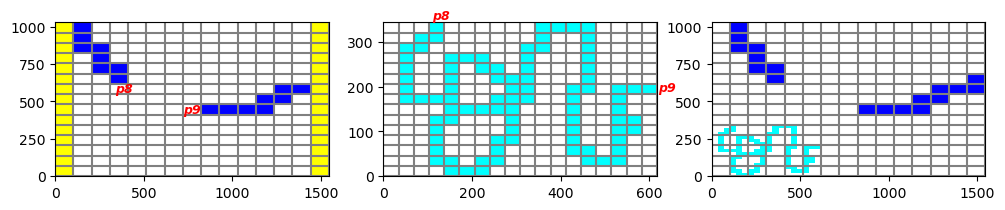

In [10]:
fig = plt.figure(figsize=(12, 2)) ; fig.tight_layout()     
ax = fig.add_subplot(131)  ; pmv = flopy.plot.PlotMapView(model=mf6b, ax=ax, layer=0)    ; pmv.plot_grid() ; pmv.plot_bc(name="SFR",color="blue") 
styles.add_text(ax,"p8",x=p1[0]+220,y=p1[1]+280  ,transform=False,bold=True,color="red") 
styles.add_text(ax,"p9",x=p1[0]+600,y=p1[1]+140  ,transform=False,bold=True,color="red") ; pmv.plot_bc(name="chd",color="yellow")
ax = fig.add_subplot(132)  ; pmv = flopy.plot.PlotMapView(model=mf6a, ax=ax, layer=0)    ; pmv.plot_grid() ; pmv.plot_bc(name="SFR",color="cyan")
styles.add_text(ax,"p8",x=p1[0]- 10,y=p1[1]+ 80  ,transform=False,bold=True,color="red") 
styles.add_text(ax,"p9",x=p1[0]+ 500,y=p1[1]- 80  ,transform=False,bold=True,color="red") 
ax = fig.add_subplot(133)  ; pmv = flopy.plot.PlotMapView(model=mf6b, ax=ax, layer=0)    ; pmv.plot_grid() ; pmv.plot_bc(name="SFR",color="blue")
pmv = flopy.plot.PlotMapView(model=mf6a, ax=ax, layer=0)                                 ; pmv.plot_bc(name="SFR",color="cyan") ; plt.show()

In [11]:
for kstpkper in ckstpkper:
    datc    = modobjc.get_data(kstpkper=kstpkper, text= "FLOW-JA-FACE") ; qc.append(datc)               #11
    datp    = modobjp.get_data(kstpkper=kstpkper, text= "FLOW-JA-FACE") ; qp.append(datp)               #12
    datc    = modobjc.get_data(kstpkper=kstpkper, text= "         GWF") ; gwswc.append(datc[0])         #21
    datp    = modobjp.get_data(kstpkper=kstpkper, text= "         GWF") ; gwswp.append(datp[0])         #22
    dat_fmc = modobjc.get_data(kstpkper=kstpkper, text= "    FROM-MVR") ; toMvrc.append(dat_fmc[0])     #31
    dat_fmp = modobjp.get_data(kstpkper=kstpkper, text= "    FROM-MVR") ; toMvrp.append(dat_fmp[0])     #32

In [12]:
d11 = np.array(qc[0]).T.tolist()     ; sa11=pd.DataFrame(d11); sad11=pd.DataFrame(sa11[0].to_list()) ; sad11.to_csv(sim_ws/"ef11_qc.csv") 
d12 = np.array(qp[0]).T.tolist()     ; sa12=pd.DataFrame(d12); sad12=pd.DataFrame(sa12[0].to_list()) ; sad12.to_csv(sim_ws/"ef12_qp.csv") 
d21 = np.array(gwswc[0]).T.tolist()  ; sa21=pd.DataFrame(d21)                                        ; sa21.to_csv(sim_ws/"ef21_gwswc.csv") 
d22 = np.array(gwswp[0]).T.tolist()  ; sa22=pd.DataFrame(d22)                                        ; sa22.to_csv(sim_ws/"ef22_gwswp.csv") 
d31 = np.array(toMvrc[0]).T.tolist() ; sa31=pd.DataFrame(d31)                                        ; sa31.to_csv(sim_ws/"ef31_toMvrc.csv") 
d32 = np.array(toMvrp[0]).T.tolist() ; sa32=pd.DataFrame(d32)                                        ; sa32.to_csv(sim_ws/"ef32_toMvrp.csv") 

In [13]:
all_rch_lengths = rlen[0:8] + rlenc + rlen[8:]                
rch_lengths = []
for i in np.arange(len(all_rch_lengths)):
    rch_lengths.append(np.sum(all_rch_lengths[0:i]) + (all_rch_lengths[i] / 2))  
rch_lengths2 = pd.DataFrame(rch_lengths) ; rch_lengths2.tail()    ; rch_lengths2.to_csv(sim_ws/"eg_01_rch_lengths2.csv")        # rch_L 

In [14]:
strmQ = np.zeros(len(connsp) + len(connsc))                     ; strmQ[0] = 40.0
for i, itm in enumerate(np.arange(1, len(qp[0][0]), 2)):        # ______________________ qp.append(datp)
    if qp[0][0][itm][0] <= 8:  strmQ[i + 1] = qp[0][0][itm][2]
    if i >= 8:                 break
strmQ[i] = dat_fmc[0][0][2]  
for j, jtm in enumerate(np.arange(1, len(qc[0][0]), 2)):        strmQ[i + (j + 1)] = qc[0][0][jtm][2]         

from_mvr = next(itm[2] for itm in dat_fmp[0] if itm[2] > 0)     # ______________________ toMvrp.append(dat_fmp[0])
strmQ[i + j + 2] = from_mvr

for k, ktm in enumerate(np.arange(15, len(qp[0][0]), 2)):
    strmQ[i + j + 2 + (k + 1)] = qp[0][0][ktm][2]               #; print('strmQ',strmQ,'strmQ[i]',strmQ[i])                    # strmQ 

In [15]:
gwsw_exg = np.zeros(len(connsp) + len(connsc))
for i, itm in enumerate(gwswp[0]):
    if itm[0] <= 8:     gwsw_exg[i] = itm[2]
    elif itm[0] > 8:    gwsw_exg[(len(gwsw_exg) - (len(gwswp[0]) - i))] = itm[2]
        
for j, jtm in enumerate(gwswc[0]):       gwsw_exg[8 + j] = jtm[2]                                                              # gwsw_exg 

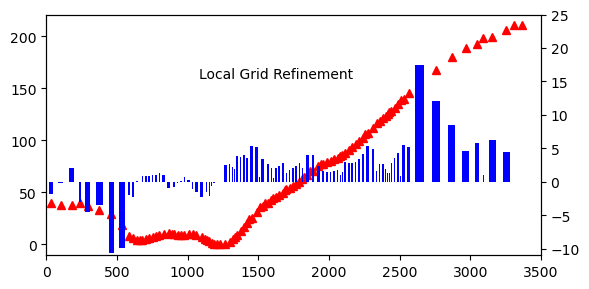

In [16]:
fig, ax1 = plt.subplots(figsize=(6,3), dpi=100, tight_layout=True)        
pts = ax1.plot(rch_lengths, strmQ, "r^", label="Stream Flow", zorder=3)      ; ax1.set_zorder(4) ; ax1.set_facecolor("none")   # rch_L x strmQ 
ax1.text(rch_lengths[int(len(rch_lengths) / 2)],160,"Local Grid Refinement",ha="center",fontsize=10)
ax2 = ax1.twinx() ; ax2.set_xlim([0, 3500]) ; ax2.set_ylim([-11, 25])
bar = ax2.bar(rch_lengths,gwsw_exg,align="center",color="b",width=[itm / 2 for itm in all_rch_lengths],label="GW-SW Exchange") # rch_L x gwsw_exg 
plt.show()